# DATA PROJECT: A dive into companies, startups and bankruptcies of the Danish private sector

**TABLE OF CONTENTS**<a id='toc0_'></a>    
- [1. Project description](#toc1_)    
- [2. Imports and set magics](#toc2_) 
- [3. Read, clean and explore data](#toc3_)
    - 3.1. [GF02 - active firms given time, industry, size and region](#toc3_1_)
    - 3.2. [DEMO4 - start-ups and bankruptcies over time and for different industries](#toc3_2_)  
- [4. Merging the datasets](#toc4_)
- [5. Analysis](#toc5_)
- [6. Concluding remarks](#toc6_)
   

## 1. <a id='toc1_'></a>[Project description](#toc0_)

The **idea behind** the project is to look at the composition of different companies in different industries in Denmark. We will do this over a period (2007-21) to see the effects that might be traceable to changes to the economy - for instance from the financial crisis in 2008-09. Moreover, we will look at tendencies to start new companies in different industries over the period and investigate in which industries there is a greate tendency towards startups. We will compare with the number of bankruptcies for the period across the different industries to evaluate the prospects of future startups in the the given industry.

With the project we want to dive into **questions** like: "are some industries mainly made up of old established companies?", "in which industries do we find a greater will to start new companies?", "what were the impacts of the financial crisis in 2008-09 on the composition of small, medium and large companies in Denmark?" and more. 

To do this we use **two datasets** from Statistics Denmark (Statistikbanken), [GF02](https://www.statistikbanken.dk/gf02) and [DEMO4](https://www.statistikbanken.dk/demo4). To get the Data we will use the Api from Statistics Denmark, DstApi. We will go more into each dataset as we read, clean and explore them below.

## 2. <a id='toc2_'></a>[Imports and set magics](#toc0_)

In [3]:
# As we will use data from Statistics Denmark (Statistikbanken) we will be using the DstApi to access that data.
# If you previously have not installed it through github, the hashtag below should be deleted and the "%pip..." line should be run.
# More info the DstApi can be found by following the link below to the githhub page explaining the Api.

#%pip install git+https://github.com/alemartinello/dstapi


In [4]:
# We import different packages for the further analysis - among these the DstApi that has been installed via the code above.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})
import datetime
import ipywidgets as widgets
from matplotlib_venn import venn2
from dstapi import DstApi

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

from dataproject import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 3. <a id='toc3_'></a>[Read, clean and explore data](#toc0_)

### 3.1. <a id='toc3_1_'></a>[GF02 - active firms given time, industry, size and region](#toc0_)

#### **IMPORT, RENAME AND DISPLAY (GF02)**

We have chosen to use the dataset [GF02](https://www.statistikbanken.dk/gf02) that contains the number of companies conditioned on area, industry (DB07), company size and year. The idea is to first examine the overall situation for the number of companies in Denmark over the period 2007-2021 depending on size and industry. From the link above, a few important things to mention are:
* The industries are determined based on Statistics Denmark industry code: DB07. We will primarily focus on the 10-grp. More on DB07 can be found [here](https://www.dst.dk/da/Statistik/dokumentation/nomenklaturer/db07#)
* 'No employed' means that only the founder of the company is regisered - an example could be a consultant with own cvr number.
* Industry code '11 Activity not stated' contains companies not defined by industry. We will take this into account later.

We start by examining the statistic using the link above, to get an idea of the expected data we will get from importing using the DstApi. Then we get an idea of how the [DstApi](https://github.com/alemartinello/dstapi) works. The code for importing via the api, setting parameters and renaming the variables can be found in the .py-file:

In [5]:
#We import the data, see the parameters and print an overview
gf02, params_gf02 = import_overview_gf02('GF02')
print(params_gf02)

Table GF02: General enterprise statistics by municipality, industry (DB07 10- 19- and 127 grouping and detailed), enterprise size (full time equivalents) and time
Last update: 2023-05-05T08:00:00
KOMK:


,id,text
0,000,All Denmark
1,084,Region Hovedstaden
2,01,Province Byen København
3,101,Copenhagen
4,147,Frederiksberg
...,...,...
113,820,Vesthimmerlands
114,851,Aalborg
115,099,Region unknown
116,098,Municipality unknown


BRANCHEDB0710TIL127:


,id,text
0,TOT,TOT Industry total
1,1,"1 Agriculture, forestry and fishing"
2,A,"A Agriculture, forestry and fishing"
3,01000,01000 Agriculture and horticulture
4,011100,"011100 Growing of cereals (except rice), legum..."
...,...,...
897,990000,990000 Activities of extraterritorial organiza...
898,11,11 Activity not stated
899,X,X Activity not stated
900,99999,99999 Activity not stated


FIRMSTR:


,id,text
0,TOT,"Total, all enterprises"
1,0000,No employed
2,010,Less than 10 employed
3,101,10-49 employees
4,102,50-249 employees
5,103,250 employees and more


Tid:


,id,text
0,2007,2007
1,2008,2008
2,2009,2009
3,2010,2010
4,2011,2011
5,2012,2012
6,2013,2013
7,2014,2014
8,2015,2015
9,2016,2016


{'table': 'gf02', 'format': 'BULK', 'lang': 'en', 'variables': [{'code': 'KOMK', 'values': ['*']}, {'code': 'BRANCHEDB0710TIL127', 'values': ['*']}, {'code': 'FIRMSTR', 'values': ['*']}, {'code': 'Tid', 'values': ['*']}]}


In [6]:
#We set the parameters and rename the variables
gf02 = params_data_gf02(gf02)
gf02

Parameters have been set successfully. An overview can be printed:


,area,industry,size,year,companies
0,All Denmark,"1 Agriculture, forestry and fishing",No employed,2007,30932
1,All Denmark,"1 Agriculture, forestry and fishing",Less than 10 employed,2007,9129
2,All Denmark,"1 Agriculture, forestry and fishing",10-49 employees,2007,369
3,All Denmark,"1 Agriculture, forestry and fishing",50-249 employees,2007,21
4,All Denmark,"1 Agriculture, forestry and fishing",250 employees and more,2007,2
...,...,...,...,...,...
1039,All Denmark,TOT Industry total,Less than 10 employed,2021,154138
1040,All Denmark,TOT Industry total,10-49 employees,2021,19594
1041,All Denmark,TOT Industry total,50-249 employees,2021,3945
1042,All Denmark,TOT Industry total,250 employees and more,2021,870


#### **CONSTRUCTING SUBSETS (GF02_SIZE & GF02_INDUSTRIES)**

For the next part we want to rename the variables to something that is easier to understand and use later on. To easier explore the data later, we want to be able to get an idea of the number of companies and changes throughout the period 2007-21 depending on either the size of companies or the industry they belong to. We do so by creating two datasets (gf02_size and gf02_industries) that we can explore later.

In [7]:
#Creating gf02_size (by removing the columns/variables 'area' and 'industry')
gf02_size = create_gf02_size(gf02)
print("gf02_size overview:")
gf02_size

gf02_size overview:


,size,year,companies
0,No employed,2007,168183
1,Less than 10 employed,2007,111481
2,10-49 employees,2007,21004
3,50-249 employees,2007,3816
4,250 employees and more,2007,835
...,...,...,...
85,Less than 10 employed,2021,154138
86,10-49 employees,2021,19594
87,50-249 employees,2021,3945
88,250 employees and more,2021,870


In [8]:
#Creating gf02_size (by removing the columns/variables 'area' and 'size')
gf02_industries = create_gf02_industries(gf02)
print("gf02_industries overview:")
gf02_industries

gf02_industries overview:


,industry,year,companies
0,"1 Agriculture, forestry and fishing",2007,40453
1,"10 Arts, entertainment and other services",2007,18498
2,11 Activity not stated,2007,1484
3,"2 Manufacturing, mining and quarrying, and uti...",2007,20814
4,3 Construction,2007,35547
...,...,...,...
175,6 Financial and insurance,2021,15224
176,7 Real estate,2021,30935
177,8 Other business services,2021,59768
178,"9 Public administration, education and health",2021,28538


#### **EXPLORING THE SUBDATASETS OF GF02**

**GF02_SIZE:**

As the original dataset appears to be a **long dataset**, so does the subdatasets. In a long dataset, each row represents a single observation, in this case, the number of companies of a specific size or in a specific industry for a particular year. The variables 'size'/'industry', 'year', and 'companies' are structured in such a way that each observation is unique, with different sizes/industries and years being repeated across multiple rows.

To explore the data we initially make a wide table and a graph for each subdataset(gf02_size and gf02_industries) using the fuctions from our .py-file:

In [9]:
# We create and show a wide dataset for size
table_size_overview(gf02_size)

,size,size2007,size2008,size2009,size2010,size2011,size2012,size2013,size2014,size2015,size2016,size2017,size2018,size2019,size2020,size2021
0,No employed,168183,168010,156529,158551,160589,161036,153368,139273,134794,142595,144520,145036,147459,147315,149898
1,Less than 10 employed,111481,117855,116338,117684,118175,118479,123337,138907,140447,143122,145775,147930,150226,151612,154138
2,10-49 employees,21004,20998,19053,17917,17938,17911,17855,17449,17771,18110,18596,19349,19141,19093,19594
3,50-249 employees,3816,3814,3379,3170,3261,3293,3270,3384,3436,3512,3628,3798,3813,3825,3945
4,250 employees and more,835,841,773,759,770,764,751,750,790,818,812,857,855,850,870
5,"Total, all enterprises",305319,311518,296072,298081,300733,301483,298581,299763,297238,308157,313331,316970,321494,322695,328445


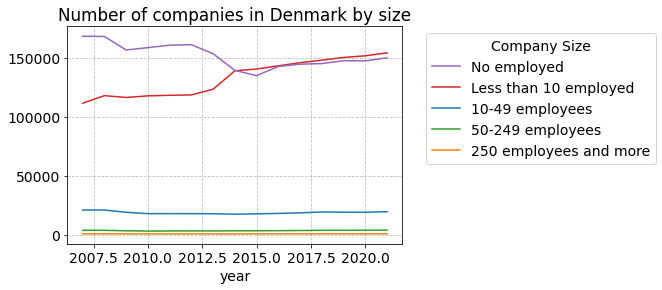

In [10]:
#We plot the numbers from the table above leaving out the total, as it would make the depiction problematic to read

plot_size_overview(gf02_size)

**Key takeaway:** 
* From the table we see that the total number of companies in Denmark for the period 2007-21 is between a low of approx 296.000 (2009) and a high of approx 328.500 (2021). The number of companies fell after the financial crisis in 2008-09 and stayed at a low level after it started increasing from around 2015.
* There are generally fewer medium-sized and big companies overall.
* All company-size groups have seen a drop after the financial crisis. However, the drop has been minor and briefly for the companies with less than 10 employed. On the other hand, the group of no employed has seen a drop until 2015. This can suggest, that some of the founders have chosen to close their business and take a job elsewhere. However, the growing number of companies with less than 10 employed, can also suggest that some of the companies with only the founder have succeeded in growing and hireing new employees, thus raising themselves from the 'No employed' category to the 'Less than 10 employed'.

To get a better understanding of the individual company-sizes we make an interactive plot using widgets:

In [11]:
# We make an interactive plot using widgets
interactive_gf02_size(gf02_size)

interactive(children=(Dropdown(description='Size', index=5, options=('No employed', 'Less than 10 employed', '…

**Key takeaway:** 
* Looking through the different size groups we see, that for the most part, there has been a tendency to an increasing number of companies from around 2014-15 and onwards. This suggests 1: more companies have been started around that time, and 2: companies already excisting have been able to hire more employees and grow to a larger company-size.
* The effects of the financial crisis becomes more evident looking at the groups individually, and thus, also how the 'Less than 10 employed' have been hit very mildly compared to the others.

**GF02_INDUSTRIES:**

To get an idea of the situation in the industries we again create a wide dataset to get a table that is easier to read and then plot the number of companies over the period for the industries.

In [12]:
#We create and show a wide dataset for industries

table_industries_overview(gf02_industries)

,industry,ind2007,ind2008,ind2009,ind2010,ind2011,ind2012,ind2013,ind2014,ind2015,ind2016,ind2017,ind2018,ind2019,ind2020,ind2021
0,"1 Agriculture, forestry and fishing",40453,38178,35176,34143,32705,32571,30722,29631,27618,27411,26185,26217,25835,25944,25428
1,"2 Manufacturing, mining and quarrying, and uti...",20814,20986,20349,20155,20312,20228,19667,19584,19341,19610,19698,19747,19840,19629,19636
2,3 Construction,35547,36024,33135,31588,31575,31300,30707,31280,31197,31973,32643,33306,33937,34756,35949
3,4 Trade and transport etc.,76256,74640,70950,71035,70428,69508,67656,66781,65635,66816,67559,67121,67149,66412,67232
4,5 Information and communication,11384,12217,12388,13597,14588,14962,15409,16109,16109,17130,17992,18492,18970,19003,19448
5,6 Financial and insurance,7720,10948,8602,9336,8983,9169,9301,10050,10943,12045,12818,13600,14141,14486,15224
6,7 Real estate,26176,26842,24489,24664,27220,27398,27574,27464,26935,28448,29216,29654,29644,30296,30935
7,8 Other business services,43195,44759,43267,45520,47637,48347,48810,50021,50038,53054,54721,55923,57584,57904,59768
8,"9 Public administration, education and health",23792,25064,26273,25653,24272,24676,25257,25039,25495,26495,26887,26992,27669,28139,28538
9,"10 Arts, entertainment and other services",18498,20799,21095,22193,22825,23253,23427,23736,23869,25136,25605,25914,26722,26113,26252


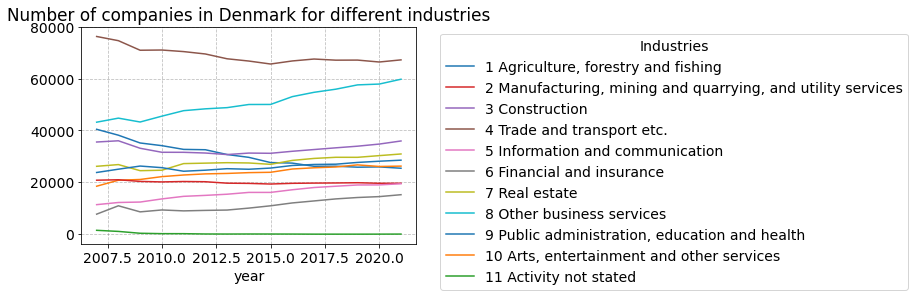

In [13]:
# We make a plot of the numbers from the table above

plot_industries_overview(gf02_industries)

**Key takeaway:** 
* From the table and the plot we see, that the trade and transport industry has the most companies in Denmark while the smallest number of companies are within financial and insurance (not including those where industry is not stated).
* There seems to have been a negative trend in the number of trade and transporting companies in general since 2007 which can suggest less activity in that industry in general or that fewer can do what previously took more companies.
* We see a similar trend in argiculture, forestry and fishing, which, given production is the same, can suggest that 1: fewer companies can produce the same (increasing productivity) or 2: larger companies operate larger amounts of land, forrest or fishing quotas.
* Not surprisingly we see a drop in construction companies after the financial crisis as we could expect from postponed building projects until better economic times (or increased government spending on infrastructure etc.).
* Only 'Information and communication' and 'Arts, entertainment and other services' seems to have been unaffected by the financial crisis in 2008-09 when looking at the number of companies. For IT this could be explained by the continuous trend of the economy and industries in general becoming more technological or low costs to start a business in that industry.


### 3.2. <a id='toc3_2_'></a>[DEMO4 - start-ups and bankruptcies over time and for different industries](#toc0_)

#### **IMPORT AND DISPLAY (DEMO4)**

The business demography statistics (DEMO4) are an annual assessment of the number of new and terminated companies, as well as the number of full-time employees and turnover. The statistics are divided by industry, ownership type, and geographical location.

In this next section of the project we apply the same approach as described with the previous dataset (GF02) to import and clean the data.


In [14]:
#We import data and set parameters
params_demo4, demo4_raw = import_demo4_data('DEMO4')
print(params_demo4)
demo4_raw.head(5)

Table DEMO4: Business Demography by region, industry (DB07 10-grouping), unit and time
Last update: 2023-05-16T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,REGION,6,000,All Denmark,081,Region Nordjylland,False
1,BRANCHEDB0710,12,TOT,TOT Industry total,11,11 Activity not stated,False
2,MÆNGDE4,5,AFU,Employees (in full-time persons),NYE,New enterprises (number),False
3,Tid,15,2007,2007,2021,2021,True


REGION:


,id,text
0,000,All Denmark
1,084,Region Hovedstaden
2,085,Region Sjælland
3,083,Region Syddanmark
4,082,Region Midtjylland
5,081,Region Nordjylland


BRANCHEDB0710:


,id,text
0,TOT,TOT Industry total
1,1,"1 Agriculture, forestry and fishing"
2,2,"2 Manufacturing, mining and quarrying, and uti..."
3,3,3 Construction
4,4,4 Trade and transport etc.
5,5,5 Information and communication
6,6,6 Financial and insurance
7,7,7 Real estate
8,8,8 Other business services
9,9,"9 Public administration, education and health"


MÆNGDE4:


,id,text
0,AFU,Employees (in full-time persons)
1,OPH,Terminated enterprises (number)
2,OMS1,Turnover (DKK 1000)
3,EKS1,Export (DKK 1000)
4,NYE,New enterprises (number)


Tid:


,id,text
0,2007,2007
1,2008,2008
2,2009,2009
3,2010,2010
4,2011,2011
5,2012,2012
6,2013,2013
7,2014,2014
8,2015,2015
9,2016,2016


{'table': 'demo4', 'format': 'BULK', 'lang': 'en', 'variables': [{'code': 'REGION', 'values': ['*']}, {'code': 'BRANCHEDB0710', 'values': ['*']}, {'code': 'MÆNGDE4', 'values': ['*']}, {'code': 'Tid', 'values': ['*']}]}


,REGION,BRANCHEDB0710,MÆNGDE4,TID,INDHOLD
0,Region Midtjylland,"2 Manufacturing, mining and quarrying, and uti...",New enterprises (number),2016,346
1,Region Midtjylland,"2 Manufacturing, mining and quarrying, and uti...",Turnover (DKK 1000),2016,487320
2,Region Midtjylland,"2 Manufacturing, mining and quarrying, and uti...",Terminated enterprises (number),2016,366
3,Region Midtjylland,3 Construction,Employees (in full-time persons),2016,186
4,Region Midtjylland,3 Construction,Export (DKK 1000),2016,..


#### **CLEANING AND RENAMING OF DEMO4**

In [15]:
# We clean and display the data
demo4 = clean_demo4_data(demo4_raw)
demo4

Cleaning has been done successfully.


,industry,x,year,total
0,TOT Industry total,Employees (in full-time persons),2016,8426
1,TOT Industry total,Export (DKK 1000),2016,..
2,TOT Industry total,New enterprises (number),2016,34116
3,TOT Industry total,Turnover (DKK 1000),2016,23556132
4,TOT Industry total,Terminated enterprises (number),2016,27476
...,...,...,...,...
70,TOT Industry total,Employees (in full-time persons),2017,8324
71,TOT Industry total,Export (DKK 1000),2017,..
72,TOT Industry total,New enterprises (number),2017,33839
73,TOT Industry total,Turnover (DKK 1000),2017,22395684


#### **EXPLORING THE DATASET**

Again, we se that the dataset is in a long format. So for better overview we display it in a wide format

In DEMO4 we have 5 variables which we want to study their trends over the time period. By organizing the data in wide format allows us to visually inspect the changes in each variable more efficiently and this is done in the following section of this assignment.

Note, that *"Employees (in full-time persons)"* are only in the startups for that year and DOES NOT include the founder of the start up.

In [16]:
pivot_demo4(demo4)


year,x,var2007,var2008,var2009,var2010,var2011,var2012,var2013,var2014,var2015,var2016,var2017,var2018,var2019,var2020,var2021
0,Employees (in full-time persons),16081,11856,8786,9213,9858,8679,9386,9719,9523,8426,8324,8041,9078,9411,10025
1,Export (DKK 1000),2951529,3027391,2590263,1874870,..,..,..,..,..,..,..,..,..,..,..
2,New enterprises (number),36660,37197,27024,30799,33659,30696,28998,31089,29911,34116,33839,33295,33930,34779,35679
3,Terminated enterprises (number),31768,42386,37653,32278,30719,31775,31994,30989,32949,27476,30523,31294,31297,33159,37492
4,Turnover (DKK 1000),47073838,45228939,23798453,23151134,27691573,30122204,30389184,24049108,24637820,23556132,22395684,21440497,23180665,31893845,29600351


In [17]:
print(demo4.dtypes)

industry    object
x           object
year         int64
total       object
dtype: object


As you can see in the provided code above, the "total" parameter is identified as an object, rather than a numerical value. This occurs because the presence of non-numeric entries, such as '..', within the export variable's numerical column and this needs to be fixed before moving on with the analysis. To address this issue, we employ pd.to_numeric() with the errors='coerce' parameter, effectively transforming non-numeric values into NaN (Not a Number). One may opt to either eliminate or substitute NaN values according to specific requirements. Below is the code that illustrates this process.

In [18]:
# We convert 'total' column to numeric type, coercing errors to NaN
demo4['total'] = pd.to_numeric(demo4['total'], errors='coerce')

# We check for NaN values after conversion
print(demo4[demo4['total'].isna()])

              industry                  x  year  total
1   TOT Industry total  Export (DKK 1000)  2016    NaN
11  TOT Industry total  Export (DKK 1000)  2019    NaN
18  TOT Industry total  Export (DKK 1000)  2011    NaN
28  TOT Industry total  Export (DKK 1000)  2012    NaN
33  TOT Industry total  Export (DKK 1000)  2015    NaN
36  TOT Industry total  Export (DKK 1000)  2021    NaN
41  TOT Industry total  Export (DKK 1000)  2020    NaN
53  TOT Industry total  Export (DKK 1000)  2014    NaN
63  TOT Industry total  Export (DKK 1000)  2013    NaN
66  TOT Industry total  Export (DKK 1000)  2018    NaN
71  TOT Industry total  Export (DKK 1000)  2017    NaN


In this next part of the project, we successfully imported the DEMO4 API and processed the dataset, addressing issues such as non-numeric values and ensuring data is cleaned up. With the dataset now cleaned and prepared we can begin merging it with the GF02 dataset. By combining these datasets, we aim to gain deeper insights and enrich our analysis. 

## 4. <a id='toc4_'></a>[Merging the datasets](#toc0_)

Both of the datasets have the industries in common. We therefore want to adapt them, so that we can merge them on industries. This will give us the number of companies for different industries from GF02 and the employees, export, new enterprises/companies, turnover and number of terminated enterprises/companies from DEMO4. For the further analysis we are especially interested in the number of new and the number of terminated enterprises/companies.

A remark for the variable *"employees in startups"*: it is the number of total full time employed (37hrs/week). Thus, two persons each working half-time (16.5hrs/week) only count as one. Further, the founder of the company does not count.

In [19]:
# We merge the datasets using the function merge_datasets in our py.file. As we want to merge on industries we need to use demo4_raw.
gf02_demo4_merged = merge_datasets(demo4_raw, gf02_industries)
gf02_demo4_merged

,industry,year,companies,employees in startups,Export(DKK1000),startups,bankruptcies,Turnover(DKK1000)
0,"1 Agriculture, forestry and fishing",2007,40453,389,96064,2458,3917,2382060
1,"1 Agriculture, forestry and fishing",2008,38178,324,109968,2264,5001,2387493
2,"1 Agriculture, forestry and fishing",2009,35176,282,64249,1584,3936,1490702
3,"1 Agriculture, forestry and fishing",2010,34143,236,19883,1661,2885,1117631
4,"1 Agriculture, forestry and fishing",2011,32705,291,..,2220,2278,1453093
...,...,...,...,...,...,...,...,...
175,TOT Industry total,2017,313331,8324,..,33839,30523,22395684
176,TOT Industry total,2018,316970,8041,..,33295,31294,21440497
177,TOT Industry total,2019,321494,9078,..,33930,31297,23180665
178,TOT Industry total,2020,322695,9411,..,34779,33159,31893845


**Key takeaway:** As we have made the dataframes so similarly structured when sorted by industry and year, it does not make any difference in the merged dataframe above, gf02_demo4_merged, whether we use an outer, inner or left merge. In either case we have the variables from the one dataframe added to the other for a combined long dataset of 180 rows and 8 columns. Had we for instance not removed the firm-size, it could have made sense to do a different merge to keep data in either or both frames (outer merge), data that are only in both sets (inner merge) or data that are in the left or both datasets (left merge).

## 5. <a id='toc5_'></a>[Analysis](#toc0_)

#### **COMPANY SIZE SHARES FOR DIFFERENT INDUSTRIES (GF02)**

After having been inspecting gf02 on size of companies and industries, for the further analysis we have constructed a plot where we can condition on both size and industry, to further examine some of our previous results. Furthermore, we add the share (green) of size-class of the company out of the total amount of companies in the industry.

In [20]:
#We create an interactive plot to compare size and industries as well as the rates out of the total companies per industry
interactive_size_industry(gf02)

interactive(children=(Dropdown(description='Size', index=5, options=('No employed', 'Less than 10 employed', '…

**Key takeaway:** focusing on the findings from earlier, by clicking through combinations of size for selected industries we see:
* Accross all industries we see the same thing for smaller companies (less than 10 employed or no employed) to make up the predominant amount of companies.
* Looking at Argiculture, forestry and fishing we see, that there are very few large companies. There is a tendency for more medium sized companies in this industry, however, for the most part, the negative trend for companies in this industry is due to a decrease in the small companies/owners since around the time of the financial crisis.
* Looking at construction we see, that there has been a downwards trend for company sizes until around 2012. Especially those with 10-49 employees have been slow, implying that going from less than 10 employees to 10-49 is cumbersome - the exact reason why is not in the data.
* For information and communication we see and overall trend to an increasing number of companies, that is particularly driven by the smaller companies (no employed and less than 10). A decrease for especially the larger companies from around the time of the financial crisis, could indicate a downscaling of employees because of the less demand from due to the economic downturn. 

#### **CHARACTERISTICS OF DANISH COMPANIES (DEMO4)**

In this analysis, we delve into the DEMO4 dataset to explore the trends across five key variables: Employees (in full-time persons), Export (DKK 1000), New enterprises (number), Number of terminated enterprises, and Turnover (DKK 1000). 

To  visualize and analyze the total values of these variables over time, we employ an interactive dropdown-plot approach as we did for the GF02 data above. The function plot_demo4_wide is designed to dynamically generate plots based on the selected variable ('x') from a dropdown menu. This function offers the option to explore each variable individually, gaining insights into how it evolves over different time periods.

In [21]:
# We make an interactive plot
interactive_demo4(demo4)

interactive(children=(Dropdown(description='total', options=('Employees (in full-time persons)', 'Export (DKK …

**Key takeaway:** By analyzing of the  figure, it is clear that the turnover, employee count, export volumes, and number of terminated companies exhibited a marked decline during the Financial Crisis of 2008, a trend that we expect. Moreover, there is a noticeable surge in the number of newly established companies commencing from 2015. This upsurge can be becuase of the fact that the resurgence of optimism within Danish society, marking the first instance of substantial economic confidence since the Financial Crisis of 2008. This resurgence was notably reported by Danish media outlet TV2 in 2015. The period from 2008 until the COVID-19 Crisis in 2020 was the longest economic upswing in recent Danish history. This long period of economic growth has facilitated many advantages for new firms, including enhanced accessibility to financial resources.

In the next part of the assignment, we will select variables a few of the 5 variables to investigate the survival rate and startup rate across various branches within Denmark.

#### **SURVIVAL RATE AND STARTUP RATE (MERGED DATA)**

We want to get an idea of the entrepreneuralship for different industries and whether it is difficult for a startup to survive. Thus, from the excisting data we create the startup rate and the survival rate. 

First, the columns 'startups', 'bankruptcies', and 'companies' are converted to numeric data types as we did earlier.

Secoundly, the survival rate is derived by dividing the number of startups by the number of bankruptcies. Similarly, the startup rate is computed by dividing the number of startups by the total number of companies, offering insights into the prevalence of new business ventures within the broader business landscape.

In [22]:
# We convert relevant columns to numeric data type
gf02_demo4_merged['startups'] = pd.to_numeric(gf02_demo4_merged['startups'], errors='coerce')
gf02_demo4_merged['bankruptcies'] = pd.to_numeric(gf02_demo4_merged['bankruptcies'], errors='coerce')
gf02_demo4_merged['companies'] = pd.to_numeric(gf02_demo4_merged['companies'], errors='coerce')

# Calculating startup rate
gf02_demo4_merged['startup_rate'] = gf02_demo4_merged['startups'] / gf02_demo4_merged['companies']
# Calculating survival rate
gf02_demo4_merged['survival_rate'] = gf02_demo4_merged['startups'] / gf02_demo4_merged['bankruptcies']

# We display part of the df
display = ['industry','year', 'survival_rate', 'startup_rate']
gf02_demo4_merged[display]

,industry,year,survival_rate,startup_rate
0,"1 Agriculture, forestry and fishing",2007,0.627521,0.060762
1,"1 Agriculture, forestry and fishing",2008,0.452709,0.059301
2,"1 Agriculture, forestry and fishing",2009,0.402439,0.045031
3,"1 Agriculture, forestry and fishing",2010,0.575737,0.048648
4,"1 Agriculture, forestry and fishing",2011,0.974539,0.067880
...,...,...,...,...
175,TOT Industry total,2017,1.108639,0.107998
176,TOT Industry total,2018,1.063942,0.105041
177,TOT Industry total,2019,1.084129,0.105539
178,TOT Industry total,2020,1.048856,0.107777


We want to analyze the survival and startup rates across different industries in Denmark. We define a list of key sectors and assign colors for visualization. Subplots are created to display average survival and startup rates from 2007 to 2021 for each industry. See the .py-file for further details.

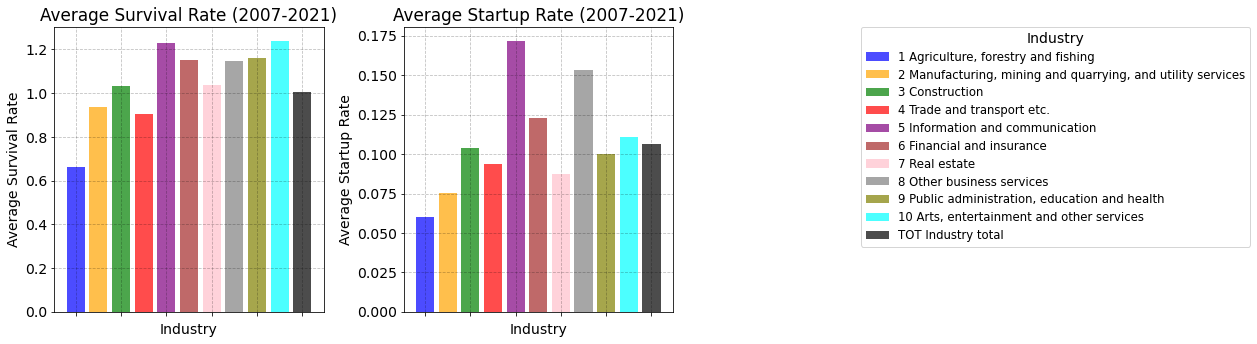

In [23]:
#We plot the rates
plot_rates(gf02_demo4_merged)

**Key takeaway:**
* As illustrated in the figure above, the agricultural sector has a survival rate below the threshold of 1, indicating a prevalence of bankruptcies is over the establishment of new enterprises within the branche. Furthermore, the agricultural sector shows the lowest startup rate among all branches, approximately ranging between 5-6% as we can see in the figure. This phenomenon may be because to the very large entry barriers characteristic of this sector. E.g. embarking on agricultural endeavors, such as pork meat farming, necessitates access to substantial financial resources, given the exorbitant costs associated with stables, machinery, livestock, land and customized equipment tailored to specific stable requirements.
* Compared to the agricultural sector, the "Information and communication" industry shows a survival rate surpassing the threshold of 1, suggesting a prevalence of sustainable ventures outweighing the incidence of business closures within this branche. This sector boasts the highest startup rate among all branches, estimated at approximately 17%. This notable trend could be attributed to the relatively low entry barriers prevalent in this market segment. In many cases, initiating endeavors within the "Information and communication" industry only requires minimal resources, such as a phone and a computer.

The real estate sector is along withh "Information and Communication" and "Agriculture" for next part of the analysis. This decision is because the anticipation of substantial changes, particularly during the 2008 financial crisis, within these specific industries.

#### **COMPARING SELECTED INDUSTRIES**

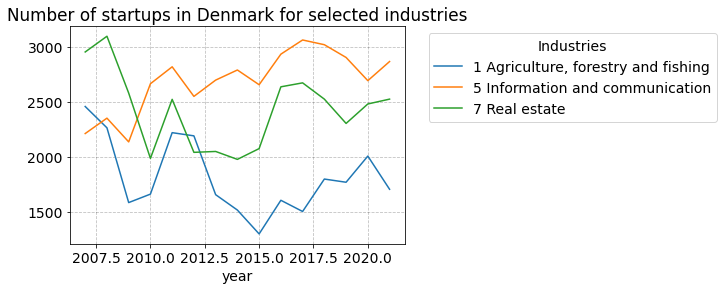

In [24]:
#We plot startups for selected industries
plot_startups(gf02_demo4_merged)

**Key takeaway:**
In the analysis presented above,  the real estate and agriculture sectors were significantly impacted by the 2008 financial crisis. This outcome was expected, given the marked downturn in housing purchases during this period and the challenges Danish farmers had when they should try to acquire necessary capital to overcome the sector's high entry barriers, such as purchasing land, stables, and livestock. The information and communication industry demonstrated resilience during the crisis by successfully attracting new entrants to the market.

From the year 2015, all three sectors observed a notable uptrend of new market participants. This trend can be due to the fact that the resurgence of optimism within Danish society and the longest economic upturn in Denmark's recent history, as previously discussed. Such trend provides new enterprises with significant benefits, including improved access to financial resources.

Bellow, we will continue the comparative analysis of the three industries, examining the number of companies within each sector and their respective developmental trajectories over the examined period.

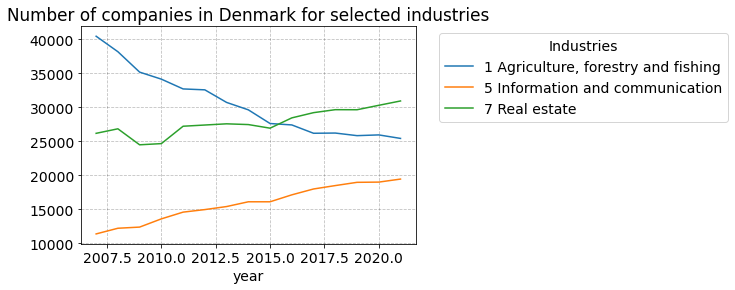

In [25]:
#We plot companies for selected industries
plot_compare_companies(gf02_demo4_merged)

**Key takeaway:** 
* The agricultural sector is experiencing a consolidation trend, with a noticeable shift from many small entities towards fewer, larger corporations. This trend likely from the strategic pursuit of economies of scale, increasingly significant in this sector, thereby raising the barriers to entry even further.
* The real estate sector witnessed a decline in company numbers following the 2008 financial crisis, succeeded by a consistent upward trajectory. This recovery aligns with the prolonged economic resurgence in Danish society, the longest in recent memory, underpinning a robust housing market historically.
* The  growth within the Information and Communication sector is presumably linked to the widespread digital transformation across all industries, reflecting a significant shift towards digitalization.

## 6. <a id='toc6_'></a>[Concluding remarks](#toc0_)

The project aimed to delve into the composition of companies across various industries in Denmark, spanning the period from 2007 to 2021. Our objective was to exmine the effects attributed to economic shifts, particularly from events such as the 2008-2009 financial crisis. Additionally, we intended to examine the propensity for new company formations within different industries during this timeframe.

To accomplish these objectives, we use two primary datasets sourced from Statistics Denmark (Statistikbanken): GF02 and DEMO4. Utilizing the DstApi provided by Statistics Denmark, we access and extract data from these datasets. We then begin to explore the data, cleansing, and analysis to unravel insights within these datasets.

In the introduction to the project, we laid out a series of questions that we intended to explore, and we have addressed these  throughout the project, covering them in the different sections.